# NLP Final Project
## Josh Coward, Ryan Pacheco, Sajia Zafreen

## Run the following 2 cells as they are always needed

In [5]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import load_dataset
import re
import transformers
from transformers import BertTokenizer, BertModel, EncoderDecoderModel
import torch
from tqdm import tqdm_notebook as tqdm
import datasets
from transformers import TrainingArguments
from transformers import Trainer
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from dataclasses import dataclass, field
from typing import Optional
import datasets
from difflib import SequenceMatcher

In [6]:
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

# Begin here if you wish to run the fine tuned BERT model. Otherwise skip to `Pre Trained Comp`

## Loading Data

In [ ]:
train_data = load_dataset("cnn_dailymail","3.0.0",split="train")
dataset = load_dataset("cnn_dailymail","3.0.0")
val_data = load_dataset("cnn_dailymail","3.0.0",split="validation")
test_data = load_dataset("cnn_dailymail","3.0.0",split="test")

## Data Preproccessing 

In [4]:
def load_data(path):
    onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    print('found {} files'.format(len(onlyfiles)))
    all_text = []
    for f in onlyfiles:
        with open('{}/{}'.format(path, f)) as handle:
            lines = clean_text(handle.readlines()[0])
            all_text.append(lines)
        
    return all_text

In [ ]:
# The following function iterates through all the articles given and creates a list of overlapping sections for each article 
# if that article is greater than 512 words  
def overlapping_subsection(dataset):
    articles = []
    for article in tqdm(dataset):
        article = article.split()
        word_count = 0
        article_subsections = []
        while len(article) > 512:
            if len(article_subsections) == 0:
                article_subsections.append(' '.join(word for word in article[:512]))
                word_count = 512
                article = article[word_count-100:]       
            if len(article) > 412:
                article_subsections.append(' '.join(word for word in article[:512]))   
                word_count = word_count + 412
                article = article[412:]
            if len(article) < 412:
                article_subsections.append(' '.join(word for word in article))   
        if len(article_subsections) != 0: 
            article = article_subsections
        articles.append(article)
    return articles

In [ ]:
# The following is the orginal data after running it through the overlapping function saved as a pandas DataFrame
train_df =  pd.DataFrame({'article':overlapping_subsection(train_data['article']),'highlights':train_data['highlights'],"id": train_data['id']})
test_df = pd.DataFrame({'article':overlapping_subsection(test_data['article']),'highlights':test_data['highlights'],"id": test_data['id']})
val_df =  pd.DataFrame({'article':overlapping_subsection(val_data['article']),'highlights':val_data['highlights'],"id": val_data['id']})

## Create Tokenizer using Bert

In [ ]:
#The tokenizer to be used to create embeddings for both Articles and Summaries
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
batch_size = 16 # Change batch size to 4 for faster but less accurate training
encoder_max_length = 512
decoder_max_length = 128

def convert_data_to_model_inputs(batch):
    #Encodes the article
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length = encoder_max_length)
    #Encodes the summary
    outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length = decoder_max_length)
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["decoder_input_ids"] = outputs.input_ids
    batch["decoder_attention_mask"] = outputs.attention_mask
    batch["labels"] = outputs.input_ids.copy()
    batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
    
    return batch
    
    

## Setup training

In [ ]:
#Note: If data has already been mapped and saved to file DO NOT run this cell

# Uncomment out the following two line two train on a small subset
# train_data = train_data.select(range(32))
# val_data = val_data.select(range(32))

train_data = train_data.map(
    convert_data_to_model_inputs,
    batched = True,
    batch_size = batch_size,
    remove_columns=["article","highlights", "id"]
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)
val_data = val_data.map(
    convert_data_to_model_inputs,
    batched = True,
    batch_size = batch_size,
    remove_columns = ["article","highlights", "id"]
)
val_data.set_format(
    type="torch", columns = ["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

### Saves Mapped Data to File

In [ ]:
# The following saves the training and validation data to file
# File size < 1.75 Gb
with open('train_data.pickle', 'wb') as handle:
    pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('val_data.pickle', 'wb') as handle:
    pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Mapped Data from File

In [ ]:
#The following loads pre-mapped train/validation data
with open('train_data.pickle', 'rb') as handle:
     train_data = pickle.load(handle)
        
with open('val_data.pickle', 'rb') as handle:
    val_data = pickle.load(handle)

In [ ]:
#Creates the base encoder decoder model
model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased","bert-base-uncased")

# set model configuration
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# sensible parameters for beam search
model.config.vocab_size = model.config.decoder.vocab_size
model.config.max_length = 128
model.config.min_length = 64
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
import datasets
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output1 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid
    rouge_output2 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge1_precision": round(rouge_output1.precision, 4),
        "rouge1_recall": round(rouge_output1.recall, 4),
        "rouge1_fmeasure": round(rouge_output1.fmeasure, 4),
        "rouge2_precision": round(rouge_output2.precision, 4),
        "rouge2_recall": round(rouge_output2.recall, 4),
        "rouge2_fmeasure": round(rouge_output2.fmeasure, 4),
    }

## Train the model

In [ ]:
#Frees up unused memory 
import gc
torch.cuda.empty_cache()
gc.collect(

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluation_strategy='steps',
    do_train=True,
    do_eval=True,
    logging_steps=1000,
    save_steps=500, 
    eval_steps=8000,
    warmup_steps=2000,  
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=True, #Comment out this line if training a non-CUDA device
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

## Evaluation

In [ ]:
model = EncoderDecoderModel.from_pretrained("checkpoint-500")
model.to("cuda") # Comment out this line if not using CUDA
batch_size = 64

def evaluate_test_data(batch):
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length = encoder_max_length,return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda") # Remove ".to("cuda")" if not using CUDA
    attention_mask = inputs.attention_mask.to("cuda") # Remove ".to("cuda")" if not using CUDA
    
    outputs = model.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch


results = test_data.map(evaluate_test_data, batched=True, batch_size=batch_size, remove_columns=["article"])

pred_str = results["pred"]
label_str = results["highlights"]

rouge_output1 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid
rouge_output2 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output1)
print(rouge_output2)

## Testing on different data

In [ ]:
article = "Our proposal looks into the reasonability, feasibility, and benefits of introducing plant-based dining options to the Boise State community. Currently, Boise State University lacks a vegan exclusive dining option on campus. This creates a variety of problems not only at the University, but at an ecological scale. With a current campus population of 22,064, there are an array of dietary restrictions, allergens, and lifestyles. Adding a plant based restaurant could help appease those students and also offer a healthier dining option. Nutrition is crucial for students and their success with studying, work ethic, and attendance. Extensive nutritional research says that plant based foods can directly affect mental capacity among school-aged children. As an example, iron deficiency can decrease dopamine transmission, thus negatively impacting a students cognition. A balanced, plant based diet can also induce better learning behaviors and learning environments. Lastly, researchers have found that plant based foods have impacted student’s exam scores and more positive school related outcomes. This also creates a convenience for students at BSU, who otherwise would search for food options off-campus. We believe there is extreme significance in this proposal that most others are unaware of. By introducing vegan options, there would be an improvement in student and faculty health for those customers. In an omnivorous diet, there are many factors that are destructive to our health. Heart disease, cancer, diabetes, obesity and strokes are just some of the few. With an ever changing environment that is rapidly increasing in warmth, humans are front and center for the cause of another imminent, mass extinction. Waste from animals whether nitrous oxide, ammonia, methane, or feces & urine, the waste amasses a total weight of 7,742,000,000 (or 7.742 billion) pounds. While the gases emitted attributes to air pollution. Research suggests that roughly 80% of ammonia emissions in the U.S comes from animal waste and it’s estimated that over 50 percent of world greenhouse gases. More than a third of all raw materials and fossil fuels consumed in the U.S. are used in animal agriculture. Researchers also state that animal agriculture is responsible for 9 percent of global carbon dioxide emissions, 35 percent to 40 percent of global methane emissions, and 65 percent of nitrous oxide emissions. These pollutants affect natural environments such as the amazon rainforest, the great barrier reef, and even places in our own backyard such as the Boise greenbelt. Not only would vegan dining options help combat climate change or health related illnesses, it would help combat future pandemics and animal cruelty. As COVID-19 continues to roar through the United States taking the lives of many, the source of the virus has been in question by conspirists yet, scientists have stated that it likely came from a wet market in Wuhan, China. Wet markets are similar to the likes of factory farms that house billions of animals worldwide annually. These compact and dirty environments that animals are bred in, and exploited, have been the source of three-fourths of the most recent pandemics in history. Diseases like SARS, HIV, COVID, Swine flu and bird flu all originated from animals being in close contact with humans. World renown doctors have compiled research and substantial evidence that if we do not change our food system, and work towards a plant based system, pandemics will become inevitable. Furthermore, authors behind a new doctor-backed white paper say they have tied most, if not all of the worlds most major outbreaks to animal exploitation since 1900. The evidence is damning, and if we do not begin working towards a plant based future, the feasibility of humankind attending universities, public gatherings, or being in physical contact with one another, becomes bleak. "
input_ids = tokenizer(article, return_tensors="pt").input_ids
output_ids = model.generate(input_ids)
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

# Begin here if you wish to just do Pre Trained model comparisions

# Pre trained comp

* Load Datasets here
* https://huggingface.co/datasets?filter=task_ids:summarization,languages:en

In [7]:
dataset_bill = load_dataset("billsum")
dataset_cnn = load_dataset("cnn_dailymail", "3.0.0")
dataset_sam = load_dataset("samsum")

Using custom data configuration default
Reusing dataset billsum (/Users/ryanpacheco/.cache/huggingface/datasets/billsum/default/3.0.0/dfbb38fcc96577d054cdcb8accc369486d1a2281a6a2ce938ad7f0b652f3416e)
Reusing dataset cnn_dailymail (/Users/ryanpacheco/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)
Reusing dataset samsum (/Users/ryanpacheco/.cache/huggingface/datasets/samsum/samsum/0.0.0/ba0b1c5c23dc00763825108e7101dbd17420ed298579d4a9fa3aec865d3e2ec3)


### Adjust the number of articles you wish to summarize

In [8]:
clean_data_cnn = []
clean_sum_cnn = []
for text in tqdm(range(len(dataset_cnn['test']['article']))[:200]):
    new = clean_text(dataset_cnn['test']['article'][text])
    clean_data_cnn.append(new)
    clean_sum_cnn.append(clean_text(dataset_cnn['test']['highlights'][text]))
    
clean_data_bill = []
clean_sum_bill = []
for text in tqdm(range(len(dataset_bill['test']['text']))[:200]):
    new = clean_text(dataset_bill['test']['text'][text])
    clean_data_bill.append(new)
    clean_sum_bill.append(clean_text(dataset_bill['test']['summary'][text]))
    
clean_data_sam = []
clean_sum_sam = []
for text in tqdm(range(len(dataset_sam['test']['dialogue']))[:200]):
    new = clean_text(dataset_sam['test']['dialogue'][text])
    clean_data_sam.append(new)
    clean_sum_sam.append(clean_text(dataset_sam['test']['summary'][text]))

<ipython-input-8-44638a81e5b4>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for text in tqdm(range(len(dataset_cnn['test']['article']))[:200]):


<ipython-input-8-44638a81e5b4>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for text in tqdm(range(len(dataset_bill['test']['text']))[:200]):


<ipython-input-8-44638a81e5b4>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for text in tqdm(range(len(dataset_sam['test']['dialogue']))[:200]):


In [9]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [10]:
from summarizer import Summarizer
from transformers import pipeline

In [11]:
model = Summarizer()

### Add more models to this list if you wish to add them to the comparision
* https://huggingface.co/models?pipeline_tag=summarization

In [12]:
sum_list = ["google/pegasus-cnn_dailymail", "t5-base", "sshleifer/distilbart-cnn-12-6", "facebook/bart-large-cnn","nsi319/legal-led-base-16384", "google/pegasus-newsroom", "google/pegasus-wikihow", "ml6team/mt5-small-german-finetune-mlsum"]

In [13]:
summarizers = {}
for name in tqdm(sum_list):
    summarizers[name] = pipeline("summarization", model=name, tokenizer=name)

<ipython-input-13-0c89655dae5f>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name in tqdm(sum_list):


Some weights of PegasusModel were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusModel were not initialized from the model checkpoint at google/pegasus-newsroom and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusModel were not initialized from the model checkpoint at google/pegasus-wikihow and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model chec

In [18]:
def summarize_models(clean_data, clean_sum, summarizers, model):
    sum_preds = {}
    for m in tqdm(summarizers):
        summary = []
        for data in tqdm(range(len(clean_data))):
            try:
                summary_text = summarizers[m](clean_data[data], clean_sum[data], max_length=100, min_length=5, do_sample=False)[0]['summary_text']
            except IndexError:
                continue
            except:
                summary_text = summarizers[m](model(clean_data[data]), clean_sum[data], max_length=100, min_length=5, do_sample=False)[0]['summary_text']
            summary.append(summary_text)
        sum_preds[m] = summary

    sum_scores = {}
    for model_name in tqdm(sum_preds):
        sum_scores[model_name] = {}
        good_score = 0
        pred = []
        gold = []
        for text_sum in range(len(sum_preds[model_name])):
            pred.append(sum_preds[model_name][text_sum])
            gold.append(clean_sum[text_sum])
            score = similar(sum_preds[model_name][text_sum], clean_sum[text_sum])
            if score > .1:
                good_score += 1
        try:
            good = rouge.compute(predictions=pred, references=gold, rouge_types=["rouge2"])["rouge2"].mid
        except:
            good = [0.0, 0.0, 0.0] 
        sum_scores[model_name]['rouge'] = good
        sum_scores[model_name]['similar'] = good_score / len(summary)


    new_scores = {}
    for model in sum_scores:
        new_scores[model] = {}
        new_scores[model]['precision'] = sum_scores[model]['rouge'][0]
        new_scores[model]['recall'] = sum_scores[model]['rouge'][1]
        new_scores[model]['fmeasure'] = sum_scores[model]['rouge'][2]
        new_scores[model]['similar'] = sum_scores[model]['similar']
    return new_scores, sum_preds

## Call summarize_modes() to summarize all the datasets that have been cleaned through all the models in the summarizers list

In [19]:
cnn_scores, cnn_preds = summarize_models(clean_data_cnn, clean_sum_cnn, summarizers, model)

<ipython-input-18-7ff9d3a1a0eb>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(summarizers):


<ipython-input-18-7ff9d3a1a0eb>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(range(len(clean_data))):


Your max_length is set to 100, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1062 > 1024). Running this sequence through the model will result in indexing errors
Your max_length is set to 100, but you input_length is only 93. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Token indices sequence length is longer than the specified maximum sequence length for this model (1062 > 1024). Running this sequence through the model will result in indexing errors
Your max_length is set to 100, but you input_length is only 93. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 100, but you input_length is only 92. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 100, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 100, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


<ipython-input-18-7ff9d3a1a0eb>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name in tqdm(sum_preds):


In [28]:
bill_scores, bill_preds = summarize_models(clean_data_bill, clean_sum_bill, summarizers, model)

<ipython-input-18-7ff9d3a1a0eb>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(summarizers):


<ipython-input-18-7ff9d3a1a0eb>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(range(len(clean_data))):


<ipython-input-18-7ff9d3a1a0eb>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name in tqdm(sum_preds):


In [29]:
sam_scores, sam_preds = summarize_models(clean_data_sam, clean_sum_sam, summarizers, model)

<ipython-input-18-7ff9d3a1a0eb>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(summarizers):


<ipython-input-18-7ff9d3a1a0eb>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(range(len(clean_data))):


Your max_length is set to 100, but you input_length is only 96. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 26. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 58. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 43. You might consider

Your max_length is set to 100, but you input_length is only 28. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 39. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 77. You might consider

Your max_length is set to 100, but you input_length is only 99. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 79. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 49. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 70. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 44. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 90. You might consider

Your max_length is set to 100, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 50. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 85. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 25. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 56. You might consider

Your max_length is set to 100, but you input_length is only 88. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 94. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 82. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 29. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 44. You might consider

Your max_length is set to 100, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 45. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 24. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 81. You might consider

Your max_length is set to 100, but you input_length is only 88. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 94. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 82. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 29. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 44. You might consider

Your max_length is set to 100, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 45. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 24. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 81. You might consider

Your max_length is set to 100, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 82. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 29. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 57. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 46. You might consider

Your max_length is set to 100, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 33. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 42. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 45. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 25. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 81. You might consider

Your max_length is set to 100, but you input_length is only 96. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 26. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 58. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 43. You might consider

Your max_length is set to 100, but you input_length is only 28. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 39. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 77. You might consider

Your max_length is set to 100, but you input_length is only 96. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 26. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 58. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 43. You might consider

Your max_length is set to 100, but you input_length is only 28. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 39. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 77. You might consider

Your max_length is set to 100, but you input_length is only 97. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 69. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 53. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 65. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 39. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 93. You might consider

Your max_length is set to 100, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 80. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 20. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 54. You might consider

<ipython-input-18-7ff9d3a1a0eb>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name in tqdm(sum_preds):


* Precision = $\frac{TP}{TP + FP}$
* Recall = $\frac{TP}{TP + FN}$
* Fmeasure = 2 * $\frac{Precision * Recall}{Precision + Recall}$

## Results
### If more models have been added copy the next two cells to show results, replacing `cnn_scores` with `{VALUE RETURNED FROM summarize_models()}`

In [30]:
for score in cnn_scores:
    print("{}:\n\tPrecision: {}\n\tRecall: {}\n\tFmeasure: {}\n\tSimilar: {}\n\t".format(score, cnn_scores[score]['precision'],cnn_scores[score]['recall'],cnn_scores[score]['fmeasure'],cnn_scores[score]['similar']))

google/pegasus-cnn_dailymail:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.42
	
t5-base:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.65
	
sshleifer/distilbart-cnn-12-6:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.415
	
facebook/bart-large-cnn:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.42
	
nsi319/legal-led-base-16384:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.51
	
google/pegasus-newsroom:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.18
	
google/pegasus-wikihow:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.175
	
ml6team/mt5-small-german-finetune-mlsum:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.585
	


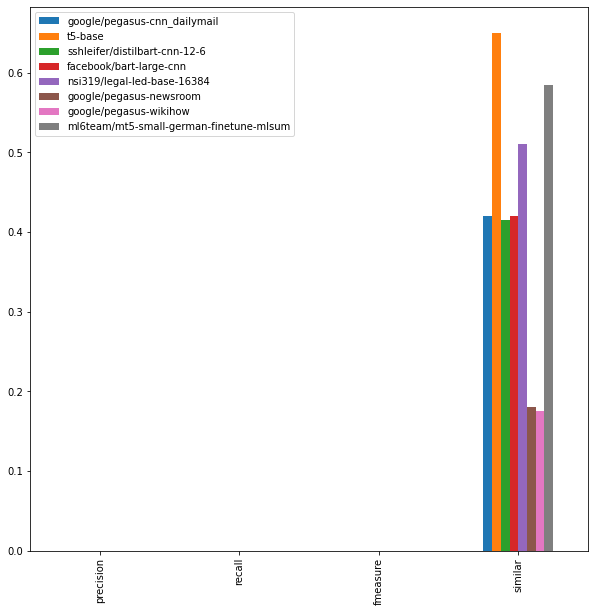

In [31]:
pd.DataFrame(cnn_scores).plot(kind='bar', figsize=(10,10))
plt.show()

In [32]:
for score in bill_scores:
    print("{}:\n\tPrecision: {}\n\tRecall: {}\n\tFmeasure: {}\n\tSimilar: {}\n\t".format(score, bill_scores[score]['precision'],bill_scores[score]['recall'],bill_scores[score]['fmeasure'],bill_scores[score]['similar']))

google/pegasus-cnn_dailymail:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.005
	
t5-base:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.18
	
sshleifer/distilbart-cnn-12-6:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.005
	
facebook/bart-large-cnn:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.005
	
nsi319/legal-led-base-16384:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.075
	
google/pegasus-newsroom:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.0
	
google/pegasus-wikihow:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.0
	
ml6team/mt5-small-german-finetune-mlsum:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.235
	


In [33]:
pd.DataFrame(bill_scores).plot(kind='bar', figsize=(10,10))
plt.show()

In [34]:
for score in sam_scores:
    print("{}:\n\tPrecision: {}\n\tRecall: {}\n\tFmeasure: {}\n\tSimilar: {}\n\t".format(score, sam_scores[score]['precision'],sam_scores[score]['recall'],sam_scores[score]['fmeasure'],sam_scores[score]['similar']))

google/pegasus-cnn_dailymail:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.965
	
t5-base:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.95
	
sshleifer/distilbart-cnn-12-6:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.965
	
facebook/bart-large-cnn:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.97
	
nsi319/legal-led-base-16384:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.93
	
google/pegasus-newsroom:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.93
	
google/pegasus-wikihow:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.895
	
ml6team/mt5-small-german-finetune-mlsum:
	Precision: 0.0
	Recall: 0.0
	Fmeasure: 0.0
	Similar: 0.845
	


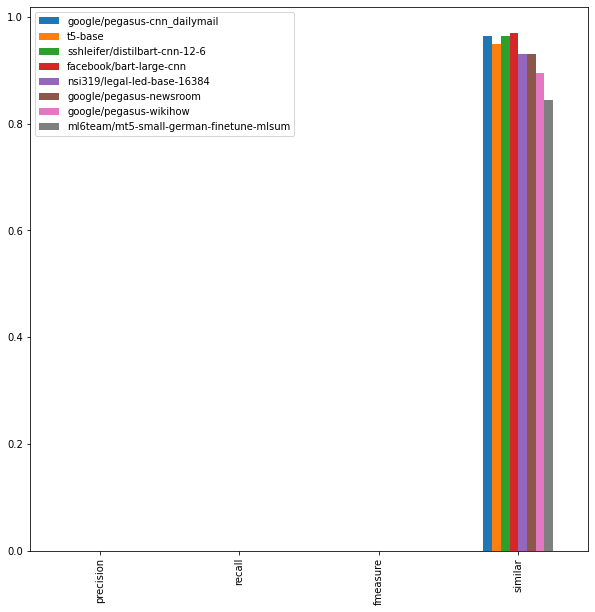

In [35]:
pd.DataFrame(sam_scores).plot(kind='bar', figsize=(10,10))
plt.show()

## Summary Results
* Call the following function with preditions, cleaned data, and what article number you wish to get summaries for
* ex: `get_summaries(cnn_preds, clean_data_cnn, 1)`

In [54]:
def get_summaries(preds, clean, article):
    print("Original Article: \n\t{}\n".format(clean[article]))
    print("Summaries: ")
    for model in preds:
        try:
            print("{}:\n\t{}\n".format(model, preds[model][article]))
        except:
            print("{}:\n\t\"\"\n".format(model))

In [55]:
get_summaries(cnn_preds, clean_data_cnn, 1)

Original Article: 
	 CNN The attorney for a suburban New York cardiologist charged in what authorities say was a failed scheme to have another physician hurt or killed is calling the allegations against his client completely unsubstantiated. Appearing Saturday morning on CNN's New Day Randy Zelin defended his client Dr. Anthony Moschetto who faces criminal solicitation conspiracy burglary arson criminal prescription sale and weapons charges in connection to what prosecutors called a plot to take out a rival doctor on Long Island. None of anything in this case has any evidentiary value Zelin told CNN's Christi Paul. It doesn't matter what anyone says he is presumed to be innocent. Moschetto 54 pleaded not guilty to all charges Wednesday. He was released after posting 2 million bond and surrendering his passport. Zelin said that his next move is to get Dr. Moshetto back to work. He's got patients to see. This man while he was in a detention cell the only thing that he cared about were hi

In [56]:
get_summaries(bill_preds, clean_data_bill, 2)

Original Article: 
	SECTION 1. SHORT TITLE. This Act may be cited as the ``Merchant Marine of World War II Congressional Gold Medal Act''. SEC. 2. FINDINGS. The Congress finds the following 1 2015 marks the 70th anniversary of the Allied victory in World War II and the restoration of peacetime across the European and Pacific theaters. 2 The United States Merchant Marine was integral in providing the link between domestic production and the fighting forces overseas providing combat equipment fuel food commodities and raw materials to troops stationed overseas. 3 Fleet Admiral Ernest J. King acknowledged the indispensability of the Merchant Marine to the victory in a 1945 letter stating that without their support ``the Navy could not have accomplished its mission''. 4 President and former Supreme Commander of the Allied Forces Dwight D. Eisenhower acknowledged that ``through the prompt delivery of supplies and equipment to our armed forces overseas and of cargoes representing economic an

In [46]:
get_summaries(sam_preds, clean_data_sam, 0)

Original Article: 
	Hannah Hey do you have Betty's number? Amanda Lemme check Hannah file_gif Amanda Sorry can't find it. Amanda Ask Larry Amanda He called her last time we were at the park together Hannah I don't know him well Hannah file_gif Amanda Don't be shy he's very nice Hannah If you say so.. Hannah I'd rather you texted him Amanda Just text him Hannah Urgh.. Alright Hannah Bye Amanda Bye bye
Summaries: 
google/pegasus-cnn_dailymail:
	He called her last time we were at the park together Hannah I don't know him well .<n>Hannah I'd rather you texted him Amanda Just text him Hannah Urgh..
t5-base:
	Hannah I don't know Larry well Hannah file_gif Amanda He called her last time we were at the park together . Hannah I'd rather you texted him .
sshleifer/distilbart-cnn-12-6:
	 Hannah Hey do you have Betty's number? Amanda Lemme Lemme check Hannah file_gif Amanda Sorry can't find it . Amanda Ask Larry Amanda ask Larry Amanda He called her last time we were at the park together Hannah I 